
# Project: OpenStreetMap Marseille data wrangling and analysis


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#audit&cleaning">Problems encountered in the map dataset</a></li>
<li><a href="#SQL_database">SQL database</a></li>
<li><a href="#overview">Overview of the data</a></li>
<li><a href="#other_ideas">Other ideas about the dataset</a></li>
<li><a href="#conclusion">Conclusions</a></li>
<li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

I decided to choose the map of Marseille, in France, as OpenStreetMap dataset for this project. I grew up in Marseille as child and then teenager, so I was keen on seeing how well this map currently is. Besides, I supposed that my knowledge of the city might help while auditing and cleaning the data (especially whenever manual corrections are needed). 

Marseille OSM data was exported from OpenStreetMap website (<a href="#ref 1">ref 1</a>) using the Overpass API: https://overpass-api.de/api/map?bbox=5.2818,43.1696,5.4502,43.3698. Note that the rectangular latitude/longitude box used for this export was chosen so that to exclude the neighboring  towns of Plan-de-Cuques, Allauch and Septèmes-les-Vallons.

This 'original' OSM file, exported on 02/11/2018 is a 360 Mb XML file. With my computer, I was not able to open it as is with NotePad++ text editor. In order to be able to tune my auditing and cleaning code, I also exported a much smaller OSM data file (only 25 Mb), focusing on the very town center of Marseille (Vieux-Port, La Canebière, Saint-Charles). 


Needed packages:

In [6]:
# Image display
from IPython.display import Image
# SQLite DB-API
import sqlite3
# Data visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

<a id='audit&cleaning'></a>
## Problems encountered in the map dataset

The aim of the data auditing and cleaning step is to prepare the OSM data in Marseille map for import in a database using the schema given in <a href="#ref 2">ref 2</a>. Systematic data type and structure validity check will be performed versus a schema (schema.py, provided in Data Wrangling case study module) using a Cerberus (<a href="#ref 3">ref 3</a>) validator. This validaty check is done "on the fly" while iterating through the OSM file and writing the CSV files that will be used to populate the SQL database.   

The following additional audits were performed:
- on data validity: 
    - are nodes and way id unique ?
    - are user names, nodes 'k' tags and ways 'k' tags strings that do not contain any problematic character ?
    - does any way element contain at least 2 different nodes references? 
- on data accuracy: are all the adresses of the OSM file present in the reference 'BAN' (Base Adresse nationale, <a href="#ref 4">ref 4</a>) ?  
- on data completeness: are there adresses present in the BAN that are missing in the OSM file ? 
- on data uniformity:
    - are latitude and longitude data in the range of expected values ?
    - are timestamp values in the range of OSM project time frame ?
    - are node/way k-tag values refering to the same quantity (height, weight, speed) expressed in the same unit (m, kg, km/h) ?  
    
### Data validity check
The different audits dealing with data validity showed good results: 
- the node and way id are unique as they should be
- no problematic character was found on user names and k-subtags strings
- all way elements contain at least 2 different node references.

However, further check of way/node consistency for 'closed' way elements showed that the guideline provided by OSM wiki (<a href="#ref 5">ref 5</a>) was not always followed. Indeed, 259 closed way elements were found where the id of the first node does not match with the id of the last node.  We went to have a look at some of them in the OSM map.

One of these closed way elements, the "Place du Château-Joly"  (way id 6312650), is shown below as an example:

Image("place_chateau_joly.png")
![Château Joly - OSM map](place_chateau_joly.png)

As can be seen, this closed way element is in fact a "closed loop" parking with its access way. The fact that the loop and the access way were tagged under the same way element makes it impossible to respect the rule given by the OSM wiki. In order to comply with OSM definition for closed way, it would be necessary to split the element into a closed loop and the access way. 


### Validity check on node and way elements' 2nd-level k-tags
We had a closer look at the node and way k-tags, where we expected to find more human-generated tags (and thus format heterogeneity, typos and other interesting information for the dataset cleaning). 

First, we saw that some k-tags ('FIXME','fixme' and 'abandoned') were used to highlight elements whose validity had to be confirmed: doubt on the location of the element, elements that have a characteristic that changed (typically an amenity that moved from one location to another)... We decided not to include in the SQL database the elements that contains one of these k-tags.

Secondly, we identified k-tags whose value shall be an integer: 'levels' (number of levels in a building) and 'capacity' (maximum number of people that can fit in the place). It was checked that these k-tags did not present any non-integer value in the OSM file.

Several k-tags were also detected whose value shall be a float: 'roof:height', 'min_height', 'maxheight', 'maxwidth', 'maxspeed', 'zone:maxspeed','maxweight'. We first checked the validity of these data: 
- only 1 'maxheight' k-tag was found with a non-float value (string '3 m' instead of just the float 3)
- only 1 'maxwidth' k-tag was found with a non-float value (string '2.2m' instead of just the float 2.2)
- only 1 'maxweight' k-tag was found with a non-float value (string '5 t' instead of just the float 5).
- zone:maxspeed was found to be homogeneously defined as a string composed of the country code (FR) followed by a colon, and then the speed limitation in km/h, i.e 'FR:30'.  

For these float k-tags, an audit of the data uniformity was also conducted. The list of values of each k-tags was plotted as a boxplot and as a histogram (see example below for 'maxheight' - the other plots can be found in the step 2 notebook). 
 Image("maxheight_boxplot&histogram.png")
![maxheight k-tag values - OSM map](maxheight_boxplot&histogram.png)

No heterogeneity in terms of unit was discovered on the box plots and histograms:
- speeds are in km/h
- widths are in m
- weights are in tons
- roof:height and max height are in m
- on the other hand, min_height is seeminlgy in cm 



### Address data accuracy and completeness
A specific look at the "addr:" k-tags showed that they were mainly used for node elements. This is where we focused our audit and cleaning.

For the city, postcode and street information of node elements, we not only checked the validity but also the accuracy and completeness of the data by comparing the content the osm map with the "Base Adresses Nationales" (BAN) database. This databse is the result of a common work involving the French "Direction générales des finances publiques" (branch of the Finance Minestry), the national institute of geographic information (IGN), Open Street Map France, and the French Post Office. 

The data from the BAN corresponding to the department of the "Bouches-du-Rhône" was exported as a CSV file from BAN website (<a href="#ref 6">ref 6</a>). In this CSV we kept the columns corresponding to the street ('voie'), the postcode ('code_post') and the city ('commune').

The audit strategy was the following: 
- Most node elements did not have addr:street neither addr:postcode nor addr:city k-tags. For these elements, we could not use the BAN database.
- When only the addr:city k-tag existed, we checked that it belonged to the list of cities extracted from the BAN. If not in the list, we looked whether there was a close match using difflib library. We corrected the cityvalue if needed.
- When there was no addr:street k-tag but at least addr:postcode k-tag, we used the BAN to check the postcode and correct it if needed. When present, the city value was cross-checked, otherwise it was created (data completion). 
- Finally, when addr:street was defined, we used the BAN to cross-check the street name. If not in the BAN streets list, we used the the difflib library to get the closest match. We then corrected/created the postcode and/or city value using the BAN.

In the OSM file, about 20000 node elements had a street information either already OK or that could easily be fixed using the BAN database. On the other hand, only about 4000 node elements had postcode and/or city information defined: the postcode/city completion process was therefore quite relevant.  


### Estimate of data completeness
We also aimed at estimating the degree of completeness of the Marseille map. We proposed a simple indicator: the ratio between the number of unique streetnames in the OSM file and in the BAN database. A ratio close to 1 means that almost all the streets in the BAN database are represented in the OSM map (in at least 1 node element). On the other hand, a low ratio means that there are several streets in the map that do not have any node element which references them. 

We found a completeness indicator of 0.22, meaning that less than 1 in 4 streets is not tagged in any node element. Several reasons can explain such a low ratio:
- [OSM map]: As stated above in introduction, the rectangular latitude/longitude box used to export OSM Marseille map was chosen so that to exclude the neighboring towns of Plan-de-Cuques, Allauch and Septèmes-les-Vallons. By doing this, and due to the shape of Marseille, some data from the North and East parts of the city was missing in the OSM file. 
- [Completeness indicator]: By design, the completeness indicator is only based on the node elements street k-tags. Considering the way-elements k-tags would improve the ratio.
- [Completeness indicator]: the indicator is based on street k-tags. These k-tags are mainly used to precise the address of a point of interest (amenity...) They are seldomly used to reference houses in residential area. In fact the defined indicator could also be seen as an estimate of the proportion of streets with at least one point of interest, as opposed to purely residential streets. With this definition a ratio of 0.22 is not suprising knowing the structure of Marseille.


### Data uniformity check on space and time

We first checked the uniformity of the elements' timestamps. According to wikipedia (<a href="#ref 7">ref 7</a>), OSM project started in 2004. Taking a little bit of margin, we expect all the entries of the dataset to have a timestamp corresponding to year above 2001 and before 2019 (as we are in November 2018). No element with unexpected timestamp was found in the Marseille OSM file.

A similar uniformity check was performed on node elements latitude and longitude data. We are dealing with data from Marseille, in France, so the latitude should be between 43 and 43.5 degrees, and the longitude should be between 5 and 6 degrees.

We expect these longitude and latitude data to be valid because the dataset was extracted from a query were the latitude and longitude are chosen. Quite surprisingly, 145 node elements were detected where the latitude and/or the longitude data was out of the expected range. See for example below the first of these elements found in the Marseille OSM file. This latitude/longitude pair corresponds to the city of Annaba, in Algeria.  

Element with unexpected latitude and/or longitude:  {'id': '66891736', 'lat': '36.8967845', 'lon': '7.7646249', 'version': '6', 'timestamp': '2017-07-06T12:58:59Z', 'changeset': '50084656', 'uid': '4860517', 'user': 'أ ش'}

These 145 node elements with inconsistent latitude or longitude information were not parsed to the SQL database.  

<a id='SQL_database'></a>
## SQL database

In this part we create the Marseille OSM SQL database and populate it with the CSV tables. To do so, we first put in the same local folder \sqlite_windows the following files:
- sqlite3.exe
- data_wrangling_schema.sql (given in <a href="#ref 2">ref 2</a>)
- the 5 CSV files with clean node and way elements data from Marseille OSM map

We then create the Marseille_OSM.db database, and import the sql schema:

In [ ]:
\sqlite_windows>sqlite3 Marseille_OSM.db 
sqlite> .read data_wrangling_schema.sql

Last step is to import the csv files into the appropriate tables:

In [ ]:
sqlite> .mode csv
sqlite> .import nodes.csv nodes
sqlite> .import nodes_tags.csv nodes_tags
sqlite> .import ways.csv ways
sqlite> .import ways_tags.csv ways_tags
sqlite> .import ways_nodes.csv ways_nodes

The SQL database is now ready for the dataset investigation. For information the file sizes is given here below:

In [ ]:
- Marseille_OSM_map.osm ..... 358 MB
- nodes.csv ................. 110 MB
- nodes_tags.csv ............ 9.8 MB
- ways.csv .................. 16 MB
- ways_tags.csv ............. 42 MB
- ways_nodes.csv ............ 49 MB
- Marseille_OSM.db .......... 202 MB

<a id='overview'></a>
## Overview of the data

### Number of nodes and ways:

In [ ]:
sqlite> select count(*) from nodes; 
sqlite> select count(*) from ways; 

Nodes: 1399810

Ways: 279431 

### Number of nodes and ways that have at least one 'tag' tag

In [ ]:
sqlite> select count(*) from (select * from nodes_tags group by id) as z;
sqlite> select count(*) from (select * from ways_tags group by id) as z;

Nodes: 58130

Ways: 278861

### Percentage of elements having at least 1 'tag' tag

In [22]:
print('Nodes: {:.1%}'.format(58130/1399810))
print('Ways: {:.1%}'.format(278861/279431))

Nodes: 4.2%
Ways: 99.8%


This percentage is much higher for way elements than for node elements. 

Now let us have a look at the average number of 'tag' tags for node and way elements that have at least 1 'tag' tag. To calculate this, we first need to know the total number of 'tag' tags for nodes and ways:

In [ ]:
sqlite> select count(*) from nodes_tags; 
sqlite> select count(*) from ways_tags;

Nodes: 203906

Ways: 681662

### Percentage of elements having at least 1 'tag' tag

In [27]:
print('Nodes: {:.1f}'.format(203906/58130))
print('Ways: {:.1f}'.format(681662/278861))

Nodes: 3.5
Ways: 2.4


The percentage of elements having at least 1 'tag' subtag is much lower for nodes than for ways. However, the 'tagged' nodes have, in average, more 'tag' subtags than the 'tagged' ways. 

### Average number of nodes per way element

To compute this average, we must divide the total number of nodes id in ways_nodes by the number of unique ways id in this same table. We multiply by 1.0 to convert the total number of nodes id from integer to float, so that the division returns a float that we can round.  

In [ ]:
sqlite> select round((select count(*) from ways_nodes)*1.0 / 
                     (select count(*) from (select * from ways_nodes group by id) as z),1);

7.7

### Number of unique users
In order to compute the number of unique users, we first combine (with UNION ALL caluse) the users that appear in the nodes and ways tables. Then, we group by user id and count the number of groups as we did above for the number of nodes with at least one 'tag' subtag.

In [ ]:
sqlite> select count (*) from (
            select count(*) from (
                select user from nodes union all select user from ways) as z 
                     group by z.user) as y;

911

<a id='other_ideas'></a>
## Other ideas about the dataset

### Distribution of tags per users

Here the aim is to have an idea of the distribution of tags per user. Were most of the tags entered by a small number of users, or do we have a large community of users who all contributed to a similar extent? Using Python SQLite DB API, we extract from the database the number of tags per user, then plot it as box plot and histogram.  

In [29]:
conn = sqlite3.connect('Marseille_OSM.db')
cursor = conn.cursor()
# the output of the quesry is a table with user name and total number of 'tags', 
# sorted in descending order of number of tags.
cursor.execute('select z.user, count(*) as num from (select user from nodes union all select user from ways) as z group by z.user order by num desc')
tag_per_user = cursor.fetchall()
conn.close()

In [35]:
# Extract list of number of tags per user from list of tuples 
nb_tags = [x[1] for x in tag_per_user]

In [33]:
# Re-use a function that was defined in sytep2 notebook
# Function that takes the list of value and the k-tag as input and plots 
# the boxplot and histogram of the values in the list.
def boxplot_and_hist(val_list,k_tag):
    plt.figure()
    # boxplot
    # the outliers will be depicted as green diamonds.
    green_diamond = dict(markerfacecolor='g', marker='D')
    ax1 = plt.subplot(1,2,1)
    ax1.set_title('Box plot')
    ax1.boxplot(val_list,flierprops=green_diamond)
    plt.xlabel('')
    plt.ylabel(k_tag);
    # histogram
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('Histogram')
    ax2.hist(val_list)
    plt.xlabel(k_tag);
    plt.ylabel('frequency');

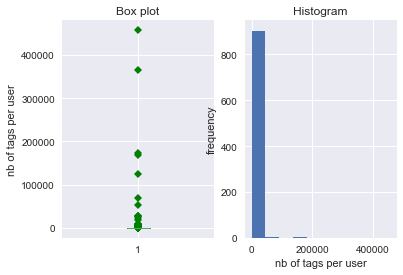

In [36]:
boxplot_and_hist(nb_tags,'nb of tags per user')

As can be seen in the box plot, there are several outliers in the upper part of the distribution. This means that a small group of user is responsible for a very large number of tags. Let us see the top 15 contributors:

In [37]:
tag_per_user[:15]

[('Emilien', 456937),
 ('Ecologeek', 365890),
 ('FrançoiseR', 174075),
 ('Jepau', 167380),
 ('Esperanza36', 125077),
 ('cquest', 69213),
 ('M GM', 51840),
 ('Jeremy G', 28254),
 ('Pieren', 27837),
 ('gbassiere', 27573),
 ('PierenBot', 23556),
 ('Virgile1994', 19034),
 ('tuxayo', 9961),
 ('MarbolanGos', 8627),
 ('jseigneuret', 8468)]

In [44]:
print('The top 7 contributors (out of 911 contributors) entered {:.0%} of the total number of tags.'.\
      format(sum(nb_tags[0:7])/sum(nb_tags)))

The top 7 contributors (out of 911 contributors) entered 84% of the total number of tags.


### Map growth dynamics

In this section we want to see how active the community of contributors has been in the last 6 years. We use queries like the one here below for year 2017 to know the number of nodes and ways elements created each year since 2013.  

In [ ]:
sqlite> select count(*) from (select timestamp from nodes union all select timestamp from ways) 
    as z where (date(z.timestamp) < '2018-01-01' and date(z.timestamp) > '2016-12-31');

Node and way elements creation:
    - 2013: 64118
    - 2014: 28817
    - 2015: 43051
    - 2016: 103196
    - 2017: 76155
    - 2018: 64797

There was a peak of contributions in 2016.

### Amenity tagging homogeneity in node elements

In this section we want to have a closer look at the tags related to amenities. First we want to count the number of tags whose key looks like amenity.

In [ ]:
sqlite> select key, count(*) as num from nodes_tags where key like 'amenit%' group by key order by num desc;

- amenity: 5177
- amenity_1: 6
- amenity_2: 1

As expected, 'amenity' is the very most commonly used keyword. Let us have a look at the tags of the nodes having 'amenity_1' as one of the key-tag. 0

In [ ]:
select * from nodes_tags where id in (select n.id from nodes n join nodes_tags nt on n.id = nt.id where nt.key == 'amenity_1');

![amenity_1_query_results - OSM map](amenity_1_query_results.png)

We see that the keys 'amenity_1' and 'amenity_2' were used when the user wanted to assign several amenity features to the same node element. 
This is not in line with the best practice "one feature, one OSM element" promoted for OSM tagging (<a href="#ref 8">ref 8</a>) 

We could split the identified nodes and ways elements with more than 1 amenity (that is those with tags amenity_1 or even amenity_2...) into separate nodes. In practice, however, this might be tricky to perform with a routine for several reasons: need to have an account (user and user id), and then need to know which new, unique node id can be used for each node we want to 'duplicate'.

<a id='conclusion'></a>
## Conclusions

The wrangling of Marseille OSM data was performed in 2 steps. First, the code to be used to audit and clean the data was tested and tuned on a smaller OSM file corresponding to the very town center. Then all these functions were integrated into a single shape_element function so that the generation of the CSV tables with clean data could be performed while looping only once over the 360 MB OSM file. An existing database of address, the BAN (<a href="#ref 6">ref 6</a>), was used to correct and/or complete street, postcode and city data when applicable. 

Once the CSV tables were imported into the SQL database, basic queries were made to have an overview of the dataset. There are more than 1.3M nodes and 250k ways, from less than 1000 contributors. It was also found that 7 contributors are responsible for the 84% of the more than 800k tags. The activity in the last 6 years shows a peak of contributions in 2016.

Two ideas for improving the data were suggested :
- when auditing the closed way elements, it was found that about 260 of them do not follow the definition given by OSM wiki.
- when querying the database for amenity tags, it was found that the keys 'amenity_1' and 'amenity_2' were used to associate several kinds of amenities to the same node element, which is not in line with OSM tagging best practice.
These improvements would make the dataset more homogeneous and standardized. However, their implementation means 'splitting' existing elements which cannot be made automatically without a strict control of the node and way elements id.

Finally, another suggestion would be to improve the address completing process by using the latitude and longitude information that is also present in the BAN database. Indeed, the proposed function may produce erroneous street-postcode-city associations if used on an OSM file where there are more than 1 city (in this case the street name is no longer unique - there is a 'Rue de la République' in almost any city in France :-). An improvement of this function would make it possible to extend the OSM dataset to a larger latitude-longitude box, while keeping the interesting address-completion feature of the code.   

<a id='ref'></a>
## References

<a id='ref 1'></a> ref 1: https://www.openstreetmap.org/

<a id='ref 2'></a> ref 2: https://gist.github.com/swwelch/f1144229848b407e0a5d13fcb7fbbd6f

<a id='ref 3'></a> ref 3: http://docs.python-cerberus.org/en/stable/

<a id='ref 4'></a> ref 4: https://adresse.data.gouv.fr/

<a id='ref 5'></a> ref 5: https://wiki.openstreetmap.org/wiki/Way#Closed_way

<a id='ref 6'></a> ref 6: https://adresse.data.gouv.fr/

<a id='ref 7'></a> ref 7: https://en.wikipedia.org/wiki/OpenStreetMap

<a id='ref 8'></a> ref 8: https://help.openstreetmap.org/questions/26625/buildings-with-more-than-one-amenity